# Model Estimation
I trained this Neighbor Comparison model by my company's lots of images.

<img src="https://image.slidesharecdn.com/deep-reidzhedong-170731023828/95/deep-reid-26-638.jpg?cb=1501473721">

## Load Model

In [1]:
from main import generate_model

In [2]:
model = generate_model(print_summary=False)
model.load_weights('./weight/checkpoint_06-0.194.weight')

Instructions for updating:
Colocations handled automatically by placer.


<summary>
    `model.summary()`
    <details>
```
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
x1_input (InputLayer)           (None, 160, 60, 3)   0                                            
__________________________________________________________________________________________________
x2_input (InputLayer)           (None, 160, 60, 3)   0                                            
__________________________________________________________________________________________________
share_conv_1 (Conv2D)           (None, 156, 56, 20)  1520        x1_input[0][0]                   
                                                                 x2_input[0][0]                   
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 78, 28, 20)   0           share_conv_1[0][0]               
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 78, 28, 20)   0           share_conv_1[1][0]               
__________________________________________________________________________________________________
share_conv_2 (Conv2D)           (None, 74, 24, 25)   12525       max_pooling2d[0][0]              
                                                                 max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 37, 12, 25)   0           share_conv_2[0][0]               
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 37, 12, 25)   0           share_conv_2[1][0]               
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 185, 60, 25)  0           max_pooling2d_3[0][0]            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 185, 60, 25)  0           max_pooling2d_2[0][0]            
__________________________________________________________________________________________________
up_sampling2d (UpSampling2D)    (None, 185, 60, 25)  0           max_pooling2d_2[0][0]            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 185, 60, 25)  0           lambda_1[0][0]                   
__________________________________________________________________________________________________
up_sampling2d_1 (UpSampling2D)  (None, 185, 60, 25)  0           max_pooling2d_3[0][0]            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 185, 60, 25)  0           lambda[0][0]                     
__________________________________________________________________________________________________
add (Add)                       (None, 185, 60, 25)  0           up_sampling2d[0][0]              
                                                                 lambda_3[0][0]                   
__________________________________________________________________________________________________
add_1 (Add)                     (None, 185, 60, 25)  0           up_sampling2d_1[0][0]            
                                                                 lambda_2[0][0]                   
__________________________________________________________________________________________________
conv_3_1 (Conv2D)               (None, 37, 12, 25)   15650       add[0][0]                        
__________________________________________________________________________________________________
conv_3_2 (Conv2D)               (None, 37, 12, 25)   15650       add_1[0][0]                      
__________________________________________________________________________________________________
conv_4_1 (Conv2D)               (None, 35, 10, 25)   5650        conv_3_1[0][0]                   
__________________________________________________________________________________________________
conv_4_2 (Conv2D)               (None, 35, 10, 25)   5650        conv_3_2[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 18, 5, 25)    0           conv_4_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 18, 5, 25)    0           conv_4_2[0][0]                   
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 18, 5, 50)    0           max_pooling2d_4[0][0]            
                                                                 max_pooling2d_5[0][0]            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 4500)         0           concatenate[0][0]                
__________________________________________________________________________________________________
dense (Dense)                   (None, 500)          2250500     flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            1002        dense[0][0]                      
==================================================================================================
Total params: 2,308,147
Trainable params: 2,308,147
Non-trainable params: 0
__________________________________________________________________________________________________
```
    </details>
</summary>

***

In [3]:
! ls img

Cross-Input.png         false-diff-369_1585.png model-for-GradCAM.png
Patch-Summary.png       false-same-1247.png     model-for-learning.png
false-diff-369_1573.png false-same-73_15309.png model-for-visualize.png


In [4]:
! tree

.
├── Estimation.ipynb
├── GradCAM.py
├── README.md
├── __pycache__
│   ├── GradCAM_model.cpython-36.pyc
│   └── main.cpython-36.pyc
├── img
│   ├── Cross-Input.png
│   ├── Patch-Summary.png
│   ├── false-diff-369_1573.png
│   ├── false-diff-369_1585.png
│   ├── false-same-1247.png
│   ├── false-same-73_15309.png
│   ├── model-for-GradCAM.png
│   ├── model-for-learning.png
│   └── model-for-visualize.png
├── main.py
├── model_from_anno.ipynb
├── pair.csv
├── train_model.ipynb
├── transfer-weights.ipynb
└── weight
    ├── GradCAM_model.hdf5
    ├── checkpoint_06-0.194.weight
    └── learning_model.hdf5

3 directories, 22 files


In [5]:
! python --version

Python 3.6.8 :: Anaconda, Inc.


## Define some functions.

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
% matplotlib inline

In [6]:
def load_img(path, grayscale=False, target_size=None, keep_aspect_ratio=False, cval=255):
    """
    関数の概要：PIL の形式で画像を読み込む。
    @param path             ：画像へのパス
    @param grayscale        ：白黒の画像に変換する = True
    @param target_size      ：(height, width)で指定する画像サイズ。指定しなければそのまま
    @param keep_aspect_ratio：リサイズした時に元画像と同じ比率を保つか。同じならば、画像を中央に置き、cval で padding.
    @param cval             ：padding する時のピクセル値。[0,255]
    """
    img = Image.open(path)

    if grayscale:
        img=img.convert('L')
    else:
        img=img.convert('RGB') # (元画像が白黒でも、αチャンネルを含んでいても 3ch に変換。)

    if target_size:
        size=(target_size[1], target_size[0])

        if not keep_aspect_ratio:
            img = img.resize(size) # 何も考えずに変換。
        else:
            if img.width > img.height:
                if img.width < w:
                    size = (img.width, img.width)
            else:
                if img.height < h:
                    size = (img.height, img.height)

            img.thumbnail(size, Image.ANTIALIAS)
            bcg=Image.new(('L' if grayscale else 'RGB'), size, (cval if grayscale else (cval, cval, cval)))
            bcg.paste(img, ((size[0] - img.size[0])//2, 
                            (size[1] - img.size[1])//2))

            if bcg.width < target_size[1]:
                bcg = bcg.resize((target_size[1], target_size[0]))
            return bcg
    return img

In [8]:
img1 = load_img('img/false-diff-369_1573.png', target_size=(160, 60), keep_aspect_ratio=False)

In [9]:
print("type of img1: {}".format(type(img1)))
print("size of img1: {}".format(img1.size))

type of img1: <class 'PIL.Image.Image'>
size of img1: (60, 160)


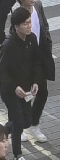

In [10]:
img1

***

In [11]:
from keras_preprocessing.image import img_to_array

In [12]:
img2 = img_to_array(img1) / 255

In [13]:
print("type  of img2: {}".format(type(img2)))
print("shape of img2: {}".format(img2.shape))

type  of img2: <class 'numpy.ndarray'>
shape of img2: (160, 60, 3)


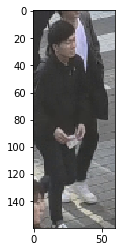

In [14]:
plt.imshow(img2)
plt.show()

***

In [15]:
import numpy as np

In [16]:
def _image_augmentation(image):
    """
    関数の概要：画像の水増しをするために、画像をランダムに平行移動させ、
    　　　　　　残りの空間を padding する。
    """
    x_padding = int(np.round(image.shape[0] * 0.05))
    y_padding = int(np.round(image.shape[1] * 0.05))
    
    padding_shape = x_padding * 2, y_padding * 2
    image_shape = np.array(image.shape[:2]) + np.array(padding_shape)
    
    image_padding = np.zeros((image_shape[0]+padding_shape[0],
                              image_shape[1]+padding_shape[1],
                              3))
    image_padding[x_padding : x_padding+image.shape[0],
                  y_padding : y_padding+image.shape[1],
                  :] = image

    x_translation = np.random.choice(x_padding * 2)
    y_translation = np.random.choice(y_padding * 2)
    
    new_image = image_padding[x_translation : x_translation+image.shape[0],
                              y_translation : y_translation+image.shape[1],
                              :]

    return new_image

In [17]:
img3 = _image_augmentation(img2)

In [18]:
print("type  of img3: {}".format(type(img3)))
print("shape of img3: {}".format(img3.shape))

type  of img3: <class 'numpy.ndarray'>
shape of img3: (160, 60, 3)


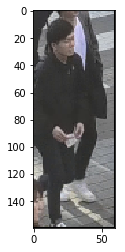

In [19]:
plt.imshow(img3)
plt.show()

***

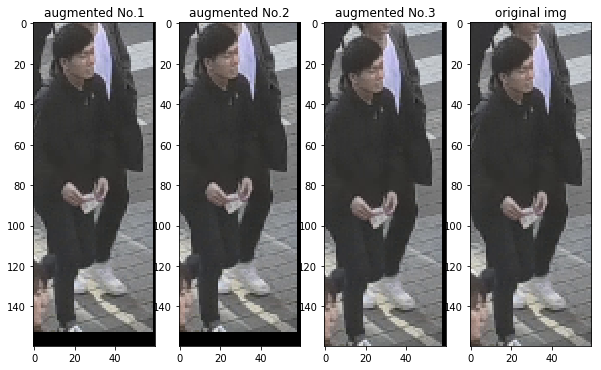

In [20]:
n = 3
plt.figure(figsize=(10,20))

for i in range(n):
    plt.subplot(1, n+1, i+1)
    plt.imshow(_image_augmentation(img2))
    plt.title("augmented No.{}".format(i+1))
    
plt.subplot(1,n+1,n+1)
plt.imshow(img2)
plt.title("original img")

plt.show()

<b>We could understand that augmentation was applied at random.</b>

***

## Demo

In [21]:
def Estimate(path1, path2, plot=False, aug=False):
    img1 = load_img(path1, target_size=(160, 60), keep_aspect_ratio=False)
    img2 = load_img(path2, target_size=(160, 60), keep_aspect_ratio=False)
    
    img1 = img_to_array(img1) / 255
    img2 = img_to_array(img2) / 255
    
    if aug:        
        img1 = _image_augmentation(img1)
        img2 = _image_augmentation(img2)
    
    if plot:
        plt.figure(figsize=(4,6))
        plt.subplot(1, 2, 1)
        plt.imshow(img1)
        plt.subplot(1, 2, 2)
        plt.imshow(img2)
        plt.show()

    img1 = np.expand_dims(img1, 0)
    img2 = np.expand_dims(img2, 0)
    img1 = img1.astype('float32')
    img2 = img2.astype('float32')
    
    print("The probability of same: {}".format(model.predict([img1, img2])[0][0]))

In [22]:
! ls img

Cross-Input.png         false-diff-369_1585.png model-for-GradCAM.png
Patch-Summary.png       false-same-1247.png     model-for-learning.png
false-diff-369_1573.png false-same-73_15309.png model-for-visualize.png


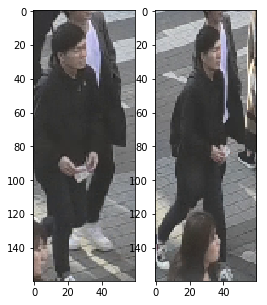

The probability of same: 0.8689013123512268


In [23]:
Estimate("./img/false-diff-369_1573.png", "./img/false-diff-369_1585.png", plot=True)

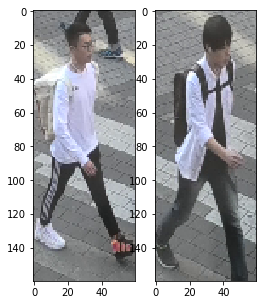

The probability of same: 0.8696675300598145


In [24]:
Estimate("./img/false-same-1247.png", "./img/false-same-73_15309.png", plot=True)

***

## GradCAM

In [1]:
from main import generate_GardCAM_model
from PIL import Image
from keras_preprocessing.image import img_to_array
import keras.backend as K
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
GradCAM_model = generate_GardCAM_model(print_summary=False)

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
GradCAM_model.load_weights("./weight/GradCAM_model.hdf5")

In [6]:
def load_img(path, grayscale=False, target_size=None, keep_aspect_ratio=False, cval=255):
    """
    関数の概要：PIL の形式で画像を読み込む。
    @param path             ：画像へのパス
    @param grayscale        ：白黒の画像に変換する = True
    @param target_size      ：(height, width)で指定する画像サイズ。指定しなければそのまま
    @param keep_aspect_ratio：リサイズした時に元画像と同じ比率を保つか。同じならば、画像を中央に置き、cval で padding.
    @param cval             ：padding する時のピクセル値。[0,255]
    """
    img = Image.open(path)

    if grayscale:
        img=img.convert('L')
    else:
        img=img.convert('RGB') # (元画像が白黒でも、αチャンネルを含んでいても 3ch に変換。)

    if target_size:
        size=(target_size[1], target_size[0])

        if not keep_aspect_ratio:
            img = img.resize(size) # 何も考えずに変換。
        else:
            if img.width > img.height:
                if img.width < w:
                    size = (img.width, img.width)
            else:
                if img.height < h:
                    size = (img.height, img.height)

            img.thumbnail(size, Image.ANTIALIAS)
            bcg=Image.new(('L' if grayscale else 'RGB'), size, (cval if grayscale else (cval, cval, cval)))
            bcg.paste(img, ((size[0] - img.size[0])//2, 
                            (size[1] - img.size[1])//2))

            if bcg.width < target_size[1]:
                bcg = bcg.resize((target_size[1], target_size[0]))
            return bcg
    return img

In [4]:
def grad_cam(model, img1, img2, category_index, layer_name="x1_conv_2"):
    nb_classes = 2
    conv_output =  [l for l in model.layers if l.name is layer_name][0].output

    one_hot = K.one_hot([category_index], nb_classes)
    signal = tf.multiply(model.output, one_hot)
    loss = K.mean(signal)

    grads = tf.gradients(loss, conv_output)[0]
    norm_grads = tf.divide(grads, K.sqrt(K.mean(K.square(grads))) + tf.constant(1e-5))

    gradient_function = K.function([model.layers[0].input, model.layers[1].input], [conv_output, norm_grads]) # img1のみを考える。

    output, grads_val = gradient_function([img1,img2])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[:2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i] # 各特徴マップを、その重要度に比率した重みを掛けて足し合わせる。

    cam = cv2.resize(cam, (160, 60)) # 元々の入力画像のサイズに整形。
    heatmap = (cam - np.min(cam)) / (np.max(cam) - np.min(cam)) # heatmap を 0-1正規化する。

    # 前処理された画像を、元のRGBの画像に戻す。
    img1 = img1[0, :]
    img1 -= np.min(img1)
    img1 = np.minimum(img1, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(img1)
    cam = 255 * (cam / np.max(cam))

    return np.uint8(cam), heatmap

In [7]:
path1 = "./img/false-diff-369_1573.png"
path2 = "./img/false-diff-369_1585.png"

img1 = load_img(path1, target_size=(160, 60), keep_aspect_ratio=False)
img2 = load_img(path2, target_size=(160, 60), keep_aspect_ratio=False)

img1 = img_to_array(img1) / 255
img2 = img_to_array(img2) / 255

img1 = np.expand_dims(img1, axis=0)
img2 = np.expand_dims(img2, axis=0)

img1 = img1.astype('float32')
img2 = img2.astype('float32')

In [8]:
predictions = GradCAM_model.predict([img1, img2])[0]
print("The probability of same: {}".format(predictions[0]))
predicted_class = np.argmax(predictions)

The probability of same: 0.8689013123512268


0

In [27]:
nb_classes = 2
conv_output =  [l for l in GradCAM_model.layers if l.name is "x1_conv_2"][0].output

one_hot = K.one_hot([predicted_class], nb_classes)
signal = tf.multiply(GradCAM_model.output, one_hot)
loss = K.mean(signal)

In [28]:
grads = tf.gradients(loss, conv_output)[0]

In [29]:
norm_grads = tf.divide(grads, K.sqrt(K.mean(K.square(grads))) + tf.constant(1e-5))

In [30]:
gradient_function = K.function([GradCAM_model.layers[0].input, GradCAM_model.layers[1].input],
                               [conv_output, norm_grads]) # img1のみを考える。

In [31]:
conv_layers_function = K.function([GradCAM_model.layers[0].input, GradCAM_model.layers[1].input],
                                  [conv_output])

In [32]:
conv_layers_function([img1,img2])

FailedPreconditionError: Error while reading resource variable conv_4_2/bias from Container: localhost. This could mean that the variable was uninitialized. Not found: Container localhost does not exist. (Could not find resource: localhost/conv_4_2/bias)
	 [[{{node conv_4_2/BiasAdd/ReadVariableOp}}]]

In [40]:
GradCAM_model.get_weights()[0].shape

(5, 5, 3, 20)

In [23]:
norm_grads_function = K.function([GradCAM_model.layers[0].input, GradCAM_model.layers[1].input],
                                  [norm_grads])

In [41]:
#norm_grads_function([img1,img2])

In [26]:
GradCAM_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x1_input (InputLayer)           (None, 160, 60, 3)   0                                            
__________________________________________________________________________________________________
x2_input (InputLayer)           (None, 160, 60, 3)   0                                            
__________________________________________________________________________________________________
x1_conv_1 (Conv2D)              (None, 156, 56, 20)  1520        x1_input[0][0]                   
__________________________________________________________________________________________________
x2_conv_1 (Conv2D)              (None, 156, 56, 20)  1520        x2_input[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [18]:
output, grads_val = gradient_function([img1,img2])

FailedPreconditionError: Error while reading resource variable x1_conv_2/kernel from Container: localhost. This could mean that the variable was uninitialized. Not found: Container localhost does not exist. (Could not find resource: localhost/x1_conv_2/kernel)
	 [[{{node x1_conv_2/Conv2D/ReadVariableOp}}]]

# 問題のコード①
```python
cam, heatmap = grad_cam(GradCAM_model, img1, img2, predicted_class, "x1_conv_2")
```

# 問題のコード②
```python
with tf.Session() as sess:
    nb_classes = 2
    conv_output =  [l for l in GradCAM_model.layers if l.name is "x1_conv_2"][0].output # 利用する特徴マップの output.
    
    one_hot = K.one_hot([predicted_class], nb_classes)
    signal = tf.multiply(GradCAM_model.output, one_hot)
    loss = K.mean(signal)
    grads = tf.gradients(loss, conv_output)[0]
    norm_grads = tf.divide(grads, K.sqrt(K.mean(K.square(grads))) + tf.constant(1e-5))

    gradient_function = K.function([GradCAM_model.layers[0].input, GradCAM_model.layers[1].input],
                                   [conv_output, norm_grads])
    
    img1 = tf.convert_to_tensor(img1)
    img2 = tf.convert_to_tensor(img2)

    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    
    conv, CAM_grads = sess.run(gradient_function([img1, img2]))
```